# Contextual Emotion Detection


## 1. Loading Data

In [1]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
import nltk
import re
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, GRU, LSTM, Bidirectional, Embedding, Dropout
from keras.callbacks import ModelCheckpoint
!pip install livelossplot

from livelossplot.tf_keras import PlotLossesCallback
from livelossplot import PlotLossesKeras

Dataset link:

In [2]:
def load_dataset(filename):
  df = pd.read_csv(filename)
  label = df["label"]
  unique_label = list(set(label))
  sentences = list(df["text"])

  return (df, label, unique_label, sentences)

In [4]:
df, label, unique_label, sentences = load_dataset('iseardataset.csv')

In [5]:
print(unique_label)

['disgust', 'joy', 'anger', 'guilt', 'sadness', 'shame', 'fear']


In [6]:
print(df.head(10))

     label                                               text Unnamed: 2
0      joy  On days when I feel close to my partner and ot...        NaN
1     fear  Every time I imagine that someone I love or I ...        NaN
2    anger  When I had been obviously unjustly treated and...        NaN
3  sadness  When I think about the short time that we live...        NaN
4  disgust  At a gathering I found myself involuntarily si...        NaN
5    shame  When I realized that I was directing the feeli...        NaN
6    guilt  I feel guilty when when I realize that I consi...        NaN
7      joy  After my girlfriend had taken her exam we went...        NaN
8     fear  When, for the first time I realized the meanin...        NaN
9    anger  When a car is overtaking another and I am forc...        NaN


<Axes: xlabel='label', ylabel='count'>

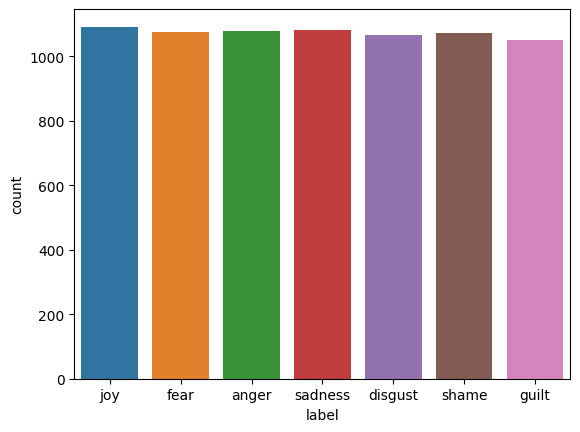

In [7]:
import seaborn as sns
import tkinter
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
%matplotlib inline
sns.countplot(x="label", data=df)

In [8]:
print(sentences[:5])

['On days when I feel close to my partner and other friends.   \nWhen I feel at peace with myself and also experience a close  \ncontact with people whom I regard greatly.', 'Every time I imagine that someone I love or I could contact a  \nserious illness, even death.', 'When I had been obviously unjustly treated and had no possibility  \nof elucidating this.', 'When I think about the short time that we live and relate it to  \nthe periods of my life when I think that I did not use this  \nshort time.', 'At a gathering I found myself involuntarily sitting next to two  \npeople who expressed opinions that I considered very low and  \ndiscriminating.']


In [9]:
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## 2. Data Cleaning

In [10]:
#define stemmer
stemmer = LancasterStemmer()

In [11]:
def cleaning(sentences):
  words = []
  for s in sentences:
    clean = re.sub(r'[^ a-z A-Z 0-9]', " ", s)
    w = word_tokenize(clean)
    words.append([i.lower() for i in w])

  return words

In [12]:
cleaned_words = cleaning(sentences)
print(len(cleaned_words))
print(cleaned_words[:2])

7516
[['on', 'days', 'when', 'i', 'feel', 'close', 'to', 'my', 'partner', 'and', 'other', 'friends', 'when', 'i', 'feel', 'at', 'peace', 'with', 'myself', 'and', 'also', 'experience', 'a', 'close', 'contact', 'with', 'people', 'whom', 'i', 'regard', 'greatly'], ['every', 'time', 'i', 'imagine', 'that', 'someone', 'i', 'love', 'or', 'i', 'could', 'contact', 'a', 'serious', 'illness', 'even', 'death']]


## 3. Texts Tokenization

In [13]:
def create_tokenizer(words, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'):
  token = Tokenizer(filters = filters)
  token.fit_on_texts(words)
  return token

In [14]:
def max_length(words):
  return(len(max(words, key = len)))

In [15]:
word_tokenizer = create_tokenizer(cleaned_words)
vocab_size = len(word_tokenizer.word_index) + 1
max_length = max_length(cleaned_words)

print("Vocab Size = %d and Maximum length = %d" % (vocab_size, max_length))

Vocab Size = 8989 and Maximum length = 179


In [16]:
def encoding_doc(token, words):
  return(token.texts_to_sequences(words))

In [17]:
encoded_doc = encoding_doc(word_tokenizer, cleaned_words)

In [18]:
def padding_doc(encoded_doc, max_length):
  return(pad_sequences(encoded_doc, maxlen = max_length, padding = "post"))

In [19]:
padded_doc = padding_doc(encoded_doc, max_length)

In [20]:
print("Shape of padded docs = ",padded_doc.shape)

Shape of padded docs =  (7516, 179)


In [21]:
#tokenizer with filter changed
output_tokenizer = create_tokenizer(unique_label, filters = '!"#$%&()*+,-/:;<=>?@[\]^`{|}~')

In [22]:
output_tokenizer.word_index

{'disgust': 1,
 'joy': 2,
 'anger': 3,
 'guilt': 4,
 'sadness': 5,
 'shame': 6,
 'fear': 7}

In [23]:
encoded_output = encoding_doc(output_tokenizer, label)

In [24]:
encoded_output = np.array(encoded_output).reshape(len(encoded_output), 1)

In [25]:
encoded_output.shape

(7516, 1)

In [26]:
def one_hot(encode):
  o = OneHotEncoder(sparse = False)
  return(o.fit_transform(encode))

In [27]:
output_one_hot = one_hot(encoded_output)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [28]:
output_one_hot.shape

(7516, 7)

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
train_X, val_X, train_Y, val_Y = train_test_split(padded_doc, output_one_hot, shuffle = True, test_size = 0.2)

In [31]:
print("Shape of train_X = %s and train_Y = %s" % (train_X.shape, train_Y.shape))
print("Shape of val_X = %s and val_Y = %s" % (val_X.shape, val_Y.shape))

Shape of train_X = (6012, 179) and train_Y = (6012, 7)
Shape of val_X = (1504, 179) and val_Y = (1504, 7)


## 4. Bidirectional GRU

In [32]:
def create_model(vocab_size, max_length):
  model = Sequential()
  model.add(Embedding(vocab_size, 128, input_length = max_length, trainable = False))
  model.add(Bidirectional(GRU(128)))
  model.add(Dense(32, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(7, activation = "softmax"))

  return model

In [ ]:
model = create_model(vocab_size, max_length)

model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 179, 128)          1150592   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              198144    
 l)                                                              
                                                                 
 dense (Dense)               (None, 32)                8224      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 7)                 231       
                                                                 
Total params: 1,357,191
Trainable params: 206,599
Non-trainable params: 1,150,592
________________________________________

In [ ]:
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

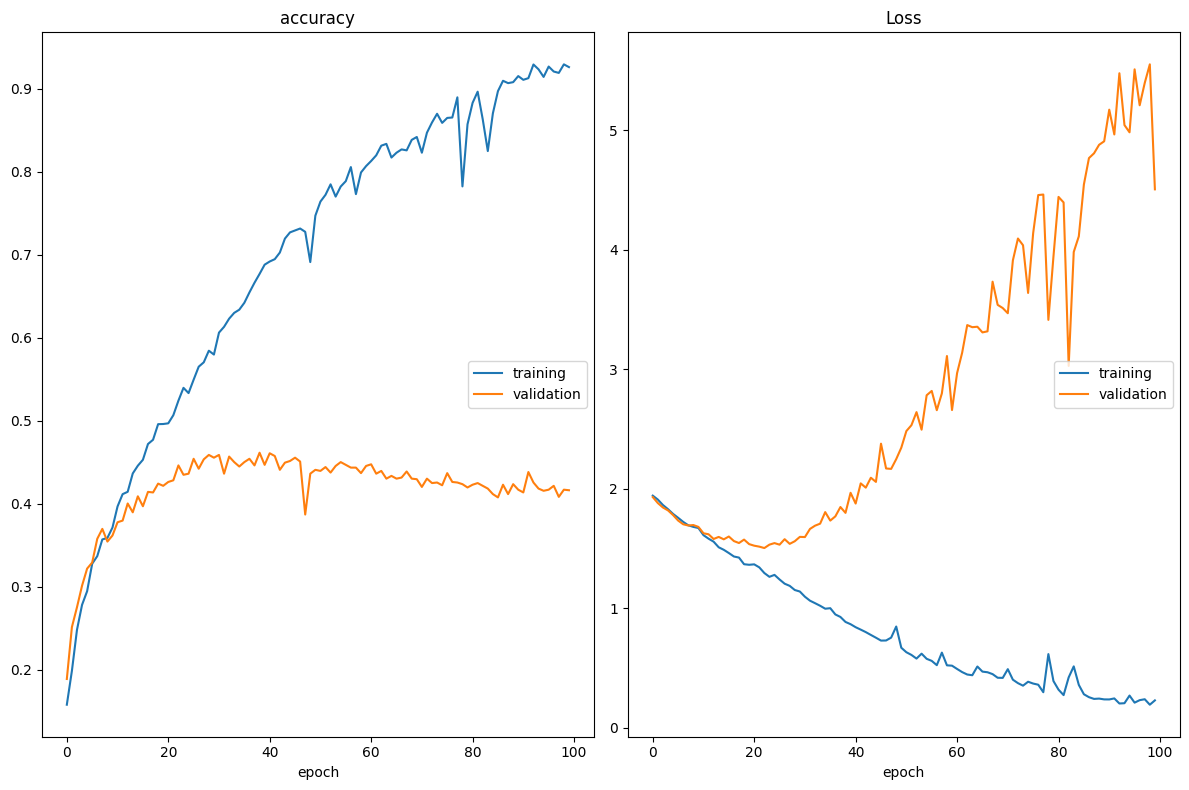

accuracy
	training         	 (min:    0.158, max:    0.929, cur:    0.926)
	validation       	 (min:    0.189, max:    0.461, cur:    0.416)
Loss
	training         	 (min:    0.193, max:    1.943, cur:    0.229)
	validation       	 (min:    1.504, max:    5.553, cur:    4.507)

Epoch 100: val_loss did not improve from 1.50418
188/188 [==============================] - 68s 361ms/step - loss: 0.2291 - accuracy: 0.9260 - val_loss: 4.5065 - val_accuracy: 0.4162


In [ ]:
hist = model.fit(train_X, train_Y,
                 epochs = 100,
                 batch_size = 32,
                 validation_data = (val_X, val_Y),
                 callbacks = [PlotLossesKeras(), checkpoint])

## 5. Bidirectional LSTM

In [95]:
def create_model(vocab_size, max_length):
  model = Sequential()
  model.add(Embedding(vocab_size, 128, input_length = max_length, trainable = False))
  model.add(Bidirectional(LSTM(128)))
  model.add(Dense(32, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(7, activation = "softmax"))

  return model

model_lstm = create_model(vocab_size, max_length)

model_lstm.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 179, 128)          1150592   
                                                                 
 bidirectional (Bidirection  (None, 256)               263168    
 al)                                                             
                                                                 
 dense (Dense)               (None, 32)                8224      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 7)                 231       
                                                                 
Total params: 1422215 (5.43 MB)
Trainable params: 271623 (1.04 MB)
Non-trainable params: 1150592 (4.39 MB)
_______________

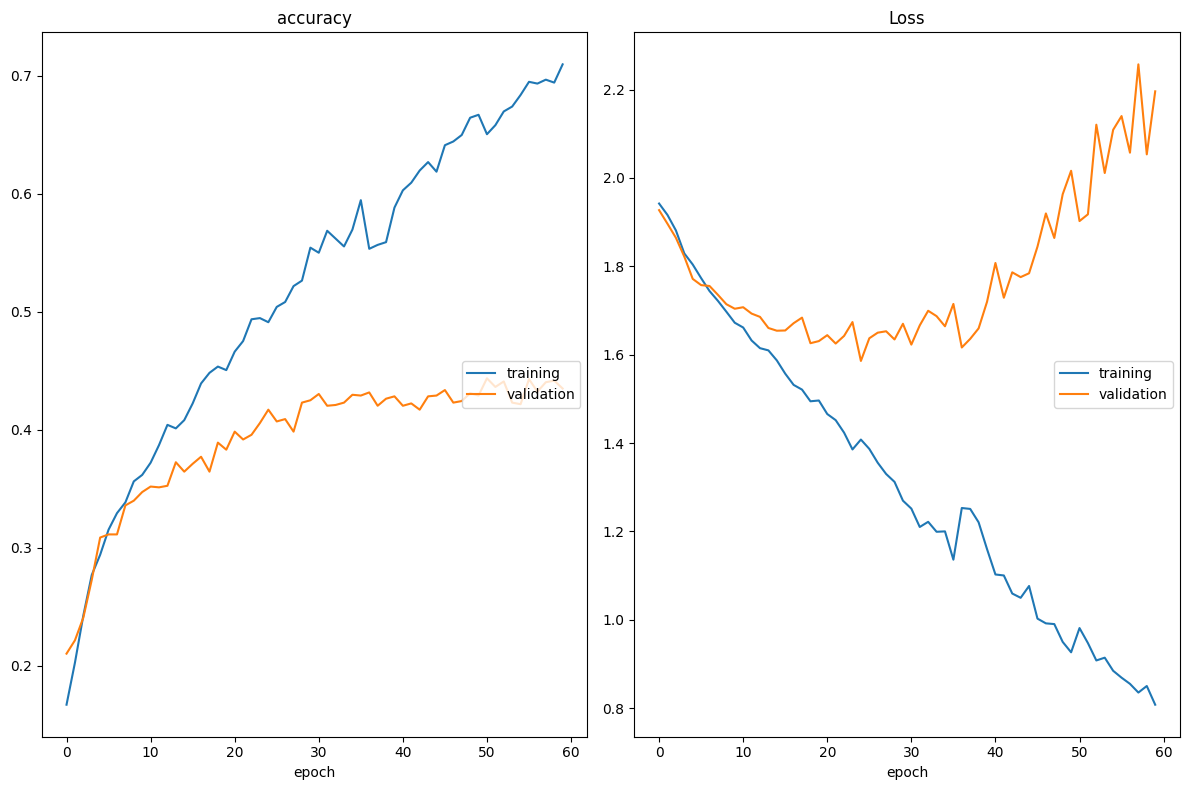

accuracy
	training         	 (min:    0.167, max:    0.710, cur:    0.710)
	validation       	 (min:    0.210, max:    0.443, cur:    0.435)
Loss
	training         	 (min:    0.808, max:    1.942, cur:    0.808)
	validation       	 (min:    1.586, max:    2.257, cur:    2.196)

Epoch 60: val_loss did not improve from 1.58574
188/188 [==============================] - 111s 590ms/step - loss: 0.8077 - accuracy: 0.7096 - val_loss: 2.1960 - val_accuracy: 0.4348


In [96]:
filename = 'model_lstm.h5'
checkpoint = ModelCheckpoint(filename,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

hist = model_lstm.fit(train_X, train_Y,
                 epochs = 60,
                 batch_size = 32,
                 validation_data = (val_X, val_Y),
                 callbacks = [PlotLossesKeras(), checkpoint])

## 6. Real-time Prediction

In [97]:
model = load_model("model_lstm.h5")

In [98]:
def predictions(text):
  clean = re.sub(r'[^ a-z A-Z 0-9]', " ", text)
  test_word = word_tokenize(clean)
  test_word = [w.lower() for w in test_word]
  test_ls = word_tokenizer.texts_to_sequences(test_word)

  if [] in test_ls:
    test_ls = list(filter(None, test_ls))

  test_ls = np.array(test_ls).reshape(1, len(test_ls))
  x = padding_doc(test_ls, max_length)

  pred = model.predict(x)

  return pred

In [99]:
def get_final_output(pred, classes):
  predictions = pred[0]
  classes = np.array(classes)
  ids = np.argsort(-predictions)
  classes = classes[ids]
  predictions = -np.sort(-predictions)

  for i in range(pred.shape[1]):
    print("%s has confidence = %s" % (classes[i], (predictions[i])))

  return classes[0]

In [100]:
def get_emotion(text):
    pred = predictions(text)
    result = get_final_output(pred, unique_label)
    print('\nans: {}\n'.format(result))

In [101]:
get_emotion("I did not help out enough at my thesis team.")

1/1 [==============================] - 1s 980ms/step
guilt has confidence = 0.7349095
shame has confidence = 0.24827927
anger has confidence = 0.008119185
sadness has confidence = 0.0038101592
disgust has confidence = 0.0020181737
joy has confidence = 0.0014704574
fear has confidence = 0.0013932902

ans: guilt



In [102]:
get_emotion("someone stole my bike.")

1/1 [==============================] - 0s 117ms/step
sadness has confidence = 0.2743273
disgust has confidence = 0.22188273
anger has confidence = 0.15876554
joy has confidence = 0.10744345
guilt has confidence = 0.08517808
shame has confidence = 0.08349242
fear has confidence = 0.06891041

ans: sadness



In [103]:
get_emotion("When my girlfriend left me and tell me that I am not fit for her.")

1/1 [==============================] - 0s 61ms/step
anger has confidence = 0.3412544
sadness has confidence = 0.26703665
disgust has confidence = 0.121077426
joy has confidence = 0.106501475
guilt has confidence = 0.07401114
shame has confidence = 0.071069054
fear has confidence = 0.019049954

ans: anger



In [104]:
get_emotion("During the Christmas holidays, I met some of my old friends.")

1/1 [==============================] - 0s 61ms/step
joy has confidence = 0.82828647
shame has confidence = 0.057951584
sadness has confidence = 0.04605706
guilt has confidence = 0.020840796
anger has confidence = 0.018853275
fear has confidence = 0.01694836
disgust has confidence = 0.011062493

ans: joy



In [109]:
get_emotion("he did not finish the work assigned to him")

1/1 [==============================] - 0s 114ms/step
shame has confidence = 0.27841023
guilt has confidence = 0.23676383
anger has confidence = 0.11609083
fear has confidence = 0.11015079
joy has confidence = 0.10827781
disgust has confidence = 0.07555795
sadness has confidence = 0.07474854

ans: shame



In [111]:
get_emotion("i am sitting on a black chair which hurts my back")

1/1 [==============================] - 0s 61ms/step
anger has confidence = 0.29828098
disgust has confidence = 0.19235988
sadness has confidence = 0.13086304
guilt has confidence = 0.11974869
shame has confidence = 0.1101899
joy has confidence = 0.09185858
fear has confidence = 0.05669891

ans: anger

